# Filtering

In *spatial filtering* of an image, we apply a given function to the gray valeues in a neighborhood of each pixel. A simple example is a function which takes the average of the 3-by-3 mask obtained by considering a pixel and its immediate neighbors:

In [1]:
# Code from first section
using PyPlot
using Statistics
A = imread("sample_photo.png")
B = mean(A, dims=3)[:,:,1]
function imshow_scale(A)
    # Like imshow(A) but scales the values to [0,1] and supports grayscale
    
    A .-= minimum(A)            # Scale and shift to [0,1]
    A ./= maximum(A)
    if ndims(A) < 3
        A = reshape(A, size(A,1), size(A,2), 1)
    end
    if size(A,3) == 1
        A = repeat(A, 1, 1, 3)  # Set R=G=B for grayscale
    end
    imshow(A)
end
function image_threshold(A, th)
    return Float64.(A .> th)
    end;

In [2]:
function image_avgfilter(A)
    B = 0*A
    for i = 2:size(A,1)-1, j = 2:size(A,2)-1
        B[i,j] = mean(A[i-1:i+1, j-1:j+1])
    end
    return B
end

image_avgfilter (generic function with 1 method)

## Smoothing

If we apply the average filter several times, and zoom in a portion of the image, we can see that it has the effect of *smoothing*, or *blurring*, the image:

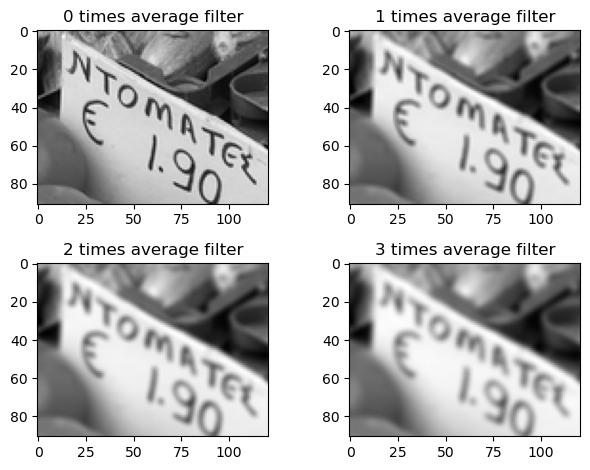

In [3]:
function filter_demo(B, filter_function)
    E = copy(B);
    for i = 0:3
        subplot(2,2,i+1); imshow_scale(E[260:350,300:420,:])
        title("$(i) times average filter")
        E = filter_function(E);
    end
    tight_layout()
end
filter_demo(B, image_avgfilter)

However, the average filter also tends to reduce certain types of noise, demonstrated below by adding normal distributed random numbers to the image:

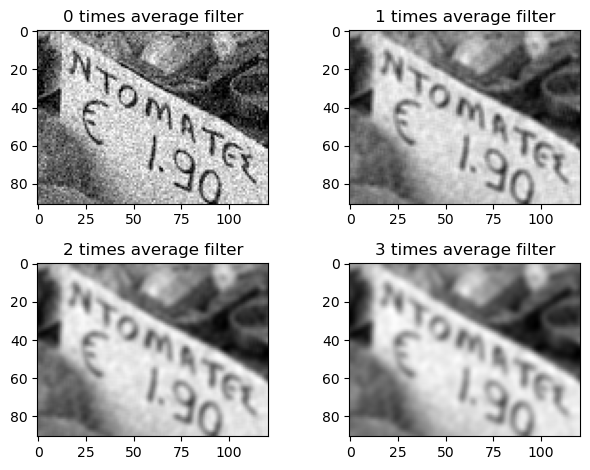

In [4]:
Bnoise = B + 0.1randn(size(B))   # Add noise
Bnoise = max.(min.(Bnoise, 1.0), 0.0) # Ensure values in [0,1]
filter_demo(Bnoise, image_avgfilter)

## Median filtering

A slight variation of the average filter is the *median filter*, which sets a pixel to the median of the gray values in the 3-by-3 neighboring mask:

In [5]:
function image_medianfilter(A)
    B = 0*A
    for i = 2:size(A,1)-1, j = 2:size(A,2)-1
        B[i,j] = median(A[i-1:i+1, j-1:j+1])
    end
    return B
end

image_medianfilter (generic function with 1 method)

The median filter is particularly good at removing noise that only affects a small number of pixels, which we model below by randomly changing only some of the pixels in the image:

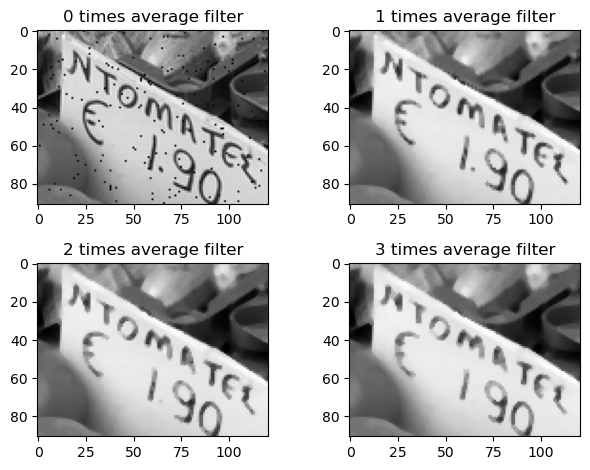

In [6]:
Bnoise2 = copy(B)
Bnoise2[rand(1:length(B), 10000)] = 0.1rand(10000)
filter_demo(Bnoise2, image_medianfilter)

## Edge detection

The previous filters tend to smooth or blur out noise and other sharp features in the image. Next we will do the opposite, and try to *detect* a sharp variation in gray values between neighboring pixels. This can be used to find the edges between regions in the image.

We will detect large changes using centered gradient approximations, that is:

$$
\nabla A_{ij} \approx
\begin{pmatrix}
A_{i+1,j} - A_{i-1,j} \\
A_{i,j+1} - A_{i,j-1} \\
\end{pmatrix}
$$

Clearly one of these components will be either large positive or large negative if there is a big jump between neighboring values, so our filter will compute the maximum of the absolute values of the gradient:

In [7]:
function image_maxabsgradfilter(A)
    B = 0*A
    for i = 2:size(A,1)-1, j = 2:size(A,2)-1
        a = A[i-1:i+1, j-1:j+1]
        B[i,j] = max(abs(a[3,2] - a[1,2]), abs(a[2,3] - a[2,1]))
    end
    return B
end

image_maxabsgradfilter (generic function with 1 method)

To improve the edge detection, we first smooth the image using the average filter before applying the gradient filter:

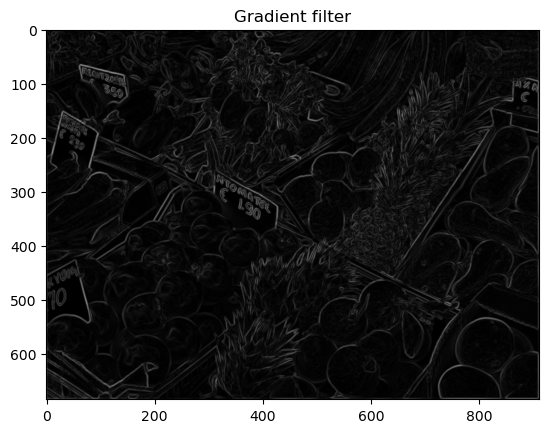

In [8]:
Bsmooth = image_avgfilter(B);
Bgrad = image_maxabsgradfilter(Bsmooth);
imshow_scale(Bgrad); title("Gradient filter");

Finally, we can threshold and invert the image to find the edges:

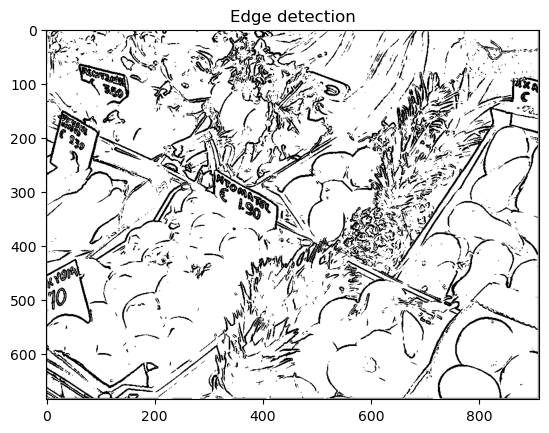

In [9]:
Bedges = 1.0 .- image_threshold(Bgrad, 0.1)
imshow_scale(Bedges); title("Edge detection");